<div style="text-align:center; font-weight:bold; font-size:35px; line-height:1.0;">EDA: Sell Your House for More </div>

<figure style="margin-top:10px"><img src="https://www.racialequityalliance.org/wp-content/uploads/2016/10/assessors_social-1.jpg" />
<figcaption style="text-align:center; font-size:8px">source: https://www.racialequityalliance.org/jurisdictions/king-county-washington/assessors_social/</figcaption>
</figure>




# Initial Imports and Data Cleaning

## How can we get more money for our house in King County?

We are selling our house and would like to know which characteristics of a home can help improve the sale price.

In order to help answer this question, we have been provided a dataset of home sales in King County which occurred during the period of September 9, 2014 through January 10, 2015.

We will attempt to model sale prices based on the other data fields and then determine which characteristics lead to an increase in sale price.

## Our Dataset

The data was provided in a csv format.  There are 21,597 sales records and 21 columns.

Column Names and descriptions:
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## Import Libraries and Custom Functions

The following code will import our custom functions from Mod1_Functions.py.

We also import pandas, numpy, matplotlib, seaborn, statsmodels, and scikit-learn.

In [1]:
from Mod1_Functions import *


## Import Raw Dataset

We import the csv data into a pandas dataframe by using `pandas.read_csv()`.

In [2]:
df_raw = pd.read_csv('kc_house_data.csv')

The code below shows the count of any data columns that are missing information.

In [3]:
missing = df_raw.shape[0] - df_raw.count()
print(missing[missing>0])

waterfront      2376
view              63
yr_renovated    3842
dtype: int64


From above, we can see that `waterfront`, `view`, and `yr_renovated` are missing values.

`date` is formatted as an object type, instead of a date (datetime64).

`sqft_basement` is also formatted as an object type, when we would expect a number format.

Let's take a look at some scatter plots of each potential X variable compared to our target `'price'`.

The custom function below accepts inputs of a dataframe and the name of the column that is the target.  Additional parameters can also be passed through to adjust the formatting.

Warnings are printed for any variables that cannot immediately be graphed as numbers, due to their datatypes.

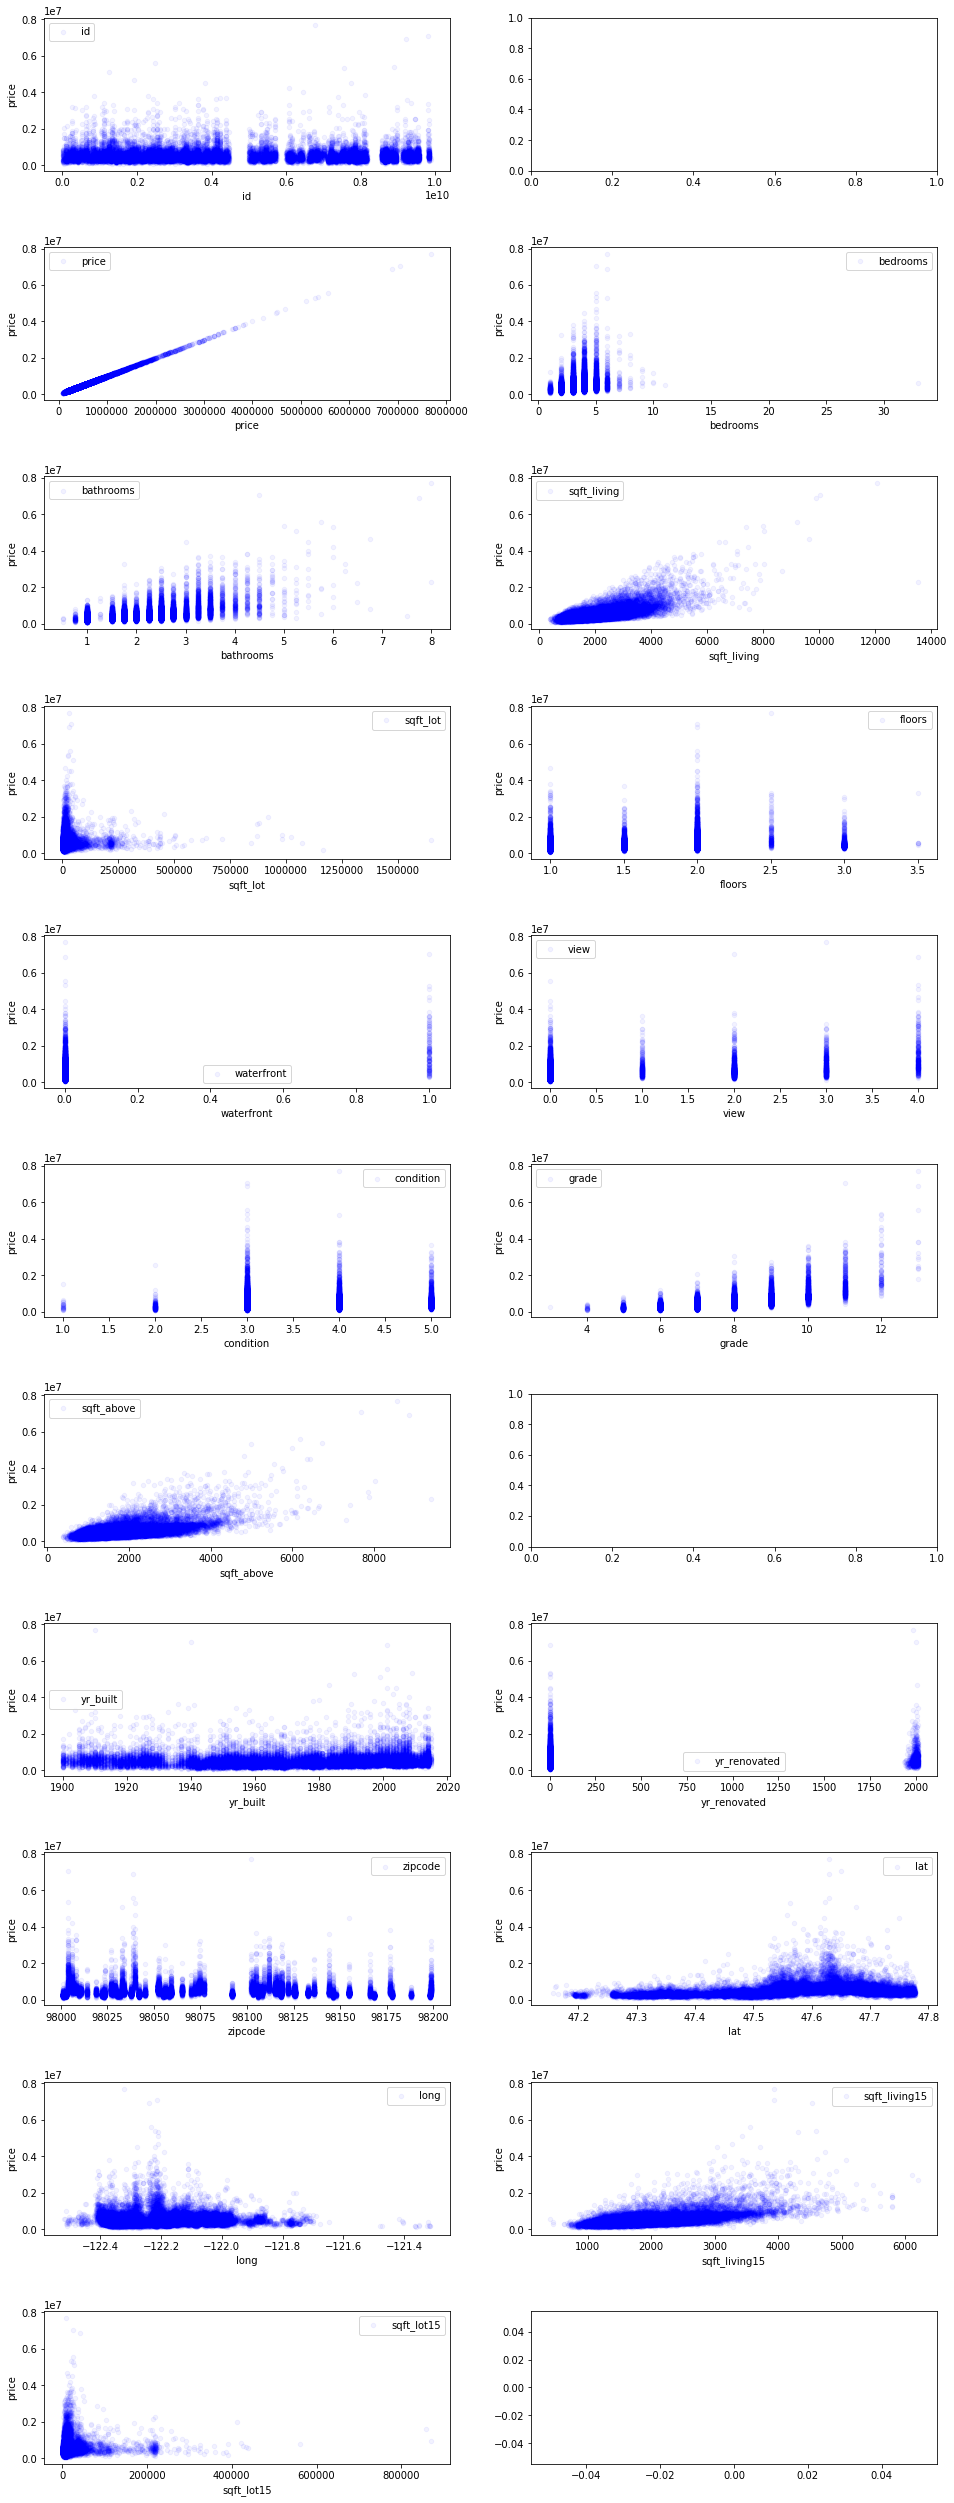

In [5]:
scatter_y(df_raw, 'price', ncols=2, figsize=(16,45))


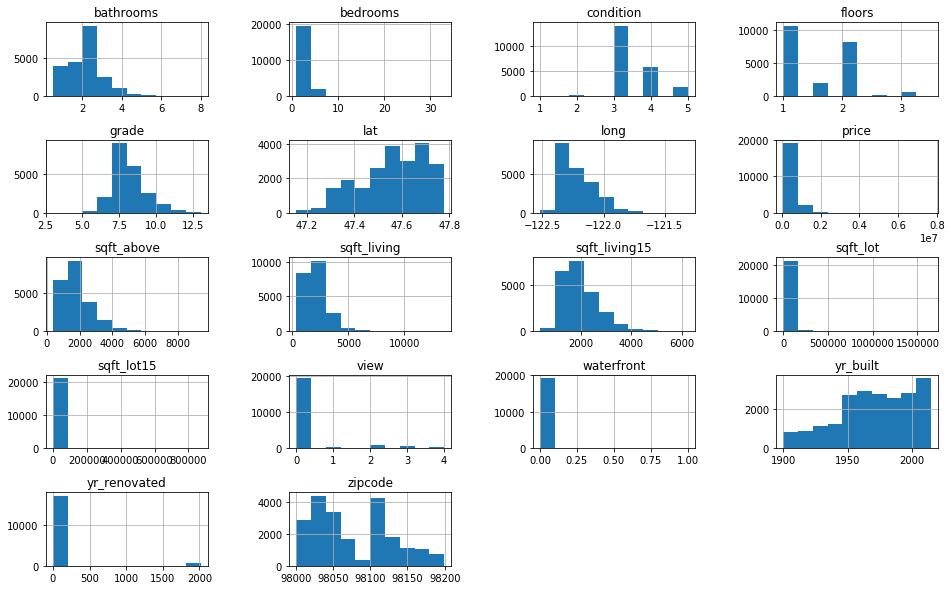

In [6]:
df_raw.iloc[:, 2:].hist(figsize  = [16, 10])
plt.subplots_adjust(wspace=0.5, hspace=0.6)

## Clean data using custom function

Our `clean_dataframe()` function takes in inputs of dataframe and a dictionary of adjustments.

We first set our `data_adjustments` dictionary to contain the fields we want to change as keys and a list of adjustments as dictionary values.

The parameters in the list are: \[datatype, value to replace, value to replace with, replacement array\]

    - datatype: must be a valid data type
    - value to replace: can be a single value string, integer, or np.nan
    - value to replace with: can be a single value or can be a list with strings containg other column names in dataframe (see replacement array below)
    - replacement array: contains a list of floats or integers, which are multiplied by the associated data field in the "value to replace with" list
    
The list items should be set to None for any parameters you do not wish to use.

We found some issues with the following data fields and decided to make some adjustments.

- `'date'` : Currently the date is formatted as a string and we would like to change it into a date (datetime64) so that we can use it in our model.


- `'bedrooms'` : There was one unusually high value of 33 bedrooms for one record.  We decided to replace that value with 4, based on the properties nearest neighbors by `'price'` and `'sqft_living'`.


- `'waterfront'`: There were 2,376 missing values in this field, which we have replaced with 'missing'.  We don't know whether these records are on the waterfront or not, but it is a significant enough proportion of records (11%), so we don't want to make an assumption about whether they are on the waterfront and also don't want to exclude them from the dataset.

In [4]:
data_adjustments = {'date': ['datetime64', None, None, None],
                    'bedrooms': [None, 33, 4, None],
                    'waterfront': [str, np.nan, 'missing', None],
                    'view': [str, np.nan, 0, None],
                    'sqft_basement': [float, '?', ['sqft_living', 'sqft_above'], [1, -1]],
                    'floors': [None, 3.5, 3, None]
                   }

In [5]:
df_clean = clean_dataframe(df_raw, data_adjustments)

## Add features calculated from other columns

We wondered whether there was any seasonality to home sale prices, so we needed to extract the month 

We created a `'month'` column in order to calculate a `'season'` column that will be used to categorize by season of the year.

We also create a custom binned variable `'yr_renovated_cat'` which categorizes whether the house has been renovated and whether that renovation was recent.

We have also add a dummy variable that classifies whether the house's square footage above ground is in the top 50% of the data set for square footage above ground.

After some work further on with the model, we determined that there were 4 zip codes where the average sales price was much higher than in other zipcodes.  Rather than consider every zipcode as a dummy variable, we decided to make a single variable for whether or not the property is in one of the 4 high priced zipcodes.

In [6]:
df_clean['month'] = df_clean['date'].map(lambda x: x.month)

df_clean['season'] = df_clean['month'].apply(create_season)

df_clean['has_basement'] = df_clean['sqft_basement'].apply(lambda x: 1 if x>0 else 0)

df_clean['sqft_above_tophalf'] = df_clean['sqft_above'].apply(lambda x: 1 if x>df_clean['sqft_above'].mean() else 0)

df_clean['zip_highprice'] = df_clean['zipcode'].apply(lambda x: 1 if x in [98004, 98039, 98040, 98112] else 0)

# Set number of years to consider recent renovation
n_years = 5
df_clean['yr_renovated_cat'] = df_clean['yr_renovated'].apply(
    renovated_cat, n_years=n_years)

## Set up data fields as Categorical to avoid treating as numbers

First we use our `set_to_categorical()` function to take the list of variables shown below and convert each to a category datatype in the dataframe.

In [7]:
categorical_columns = ['floors', 'waterfront', 'view', 'condition',
                       'grade', 'yr_renovated_cat', 'season']
# not in use: 'zipcode'
set_to_categorical(df_clean, categorical_columns)

print("Categorical Variables:")
print(df_clean.dtypes[df_clean.dtypes=='category'])


Categorical Variables:
floors              category
waterfront          category
view                category
condition           category
grade               category
season              category
yr_renovated_cat    category
dtype: object


We have made a custom function `create_dummyframe()` which generates a data frame of dummy variables for each of the variables listed in the second parameter from the original data frame.

In [8]:
df_dummy = create_dummyframe(df_clean, categorical_columns)

print('df_dummy shape: {}'.format(df_dummy.shape))
print('\nPreview:')
df_dummy.head()


df_dummy shape: (21597, 37)

Preview:


,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,waterfront_0.0,waterfront_1.0,waterfront_missing,view_0.0,view_1.0,...,grade_12,grade_13,yr_renovated_cat_Never Renovated,yr_renovated_cat_Prior to 2010,yr_renovated_cat_Since 2010 inclusive,yr_renovated_cat_missing,season_Fall,season_Spring,season_Summer,season_Winter
0,1,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


Let's take a look at the distribution of prices.

The prices appear to follow a log relationship.

Let's consider evulating a log-linear relationship by adding a `'log_price'` column.

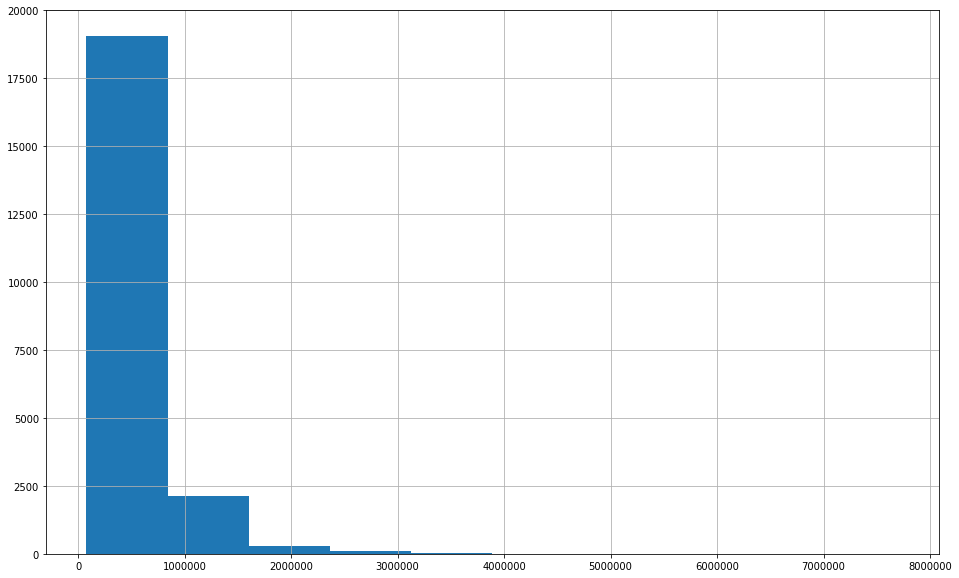

In [9]:
df_clean.price.hist(figsize  = [16, 10])

In [10]:
df_clean['log_price'] = np.log(df_clean['price'])

And take another look at the scatter plots compared to the new target of `'log_price'` 

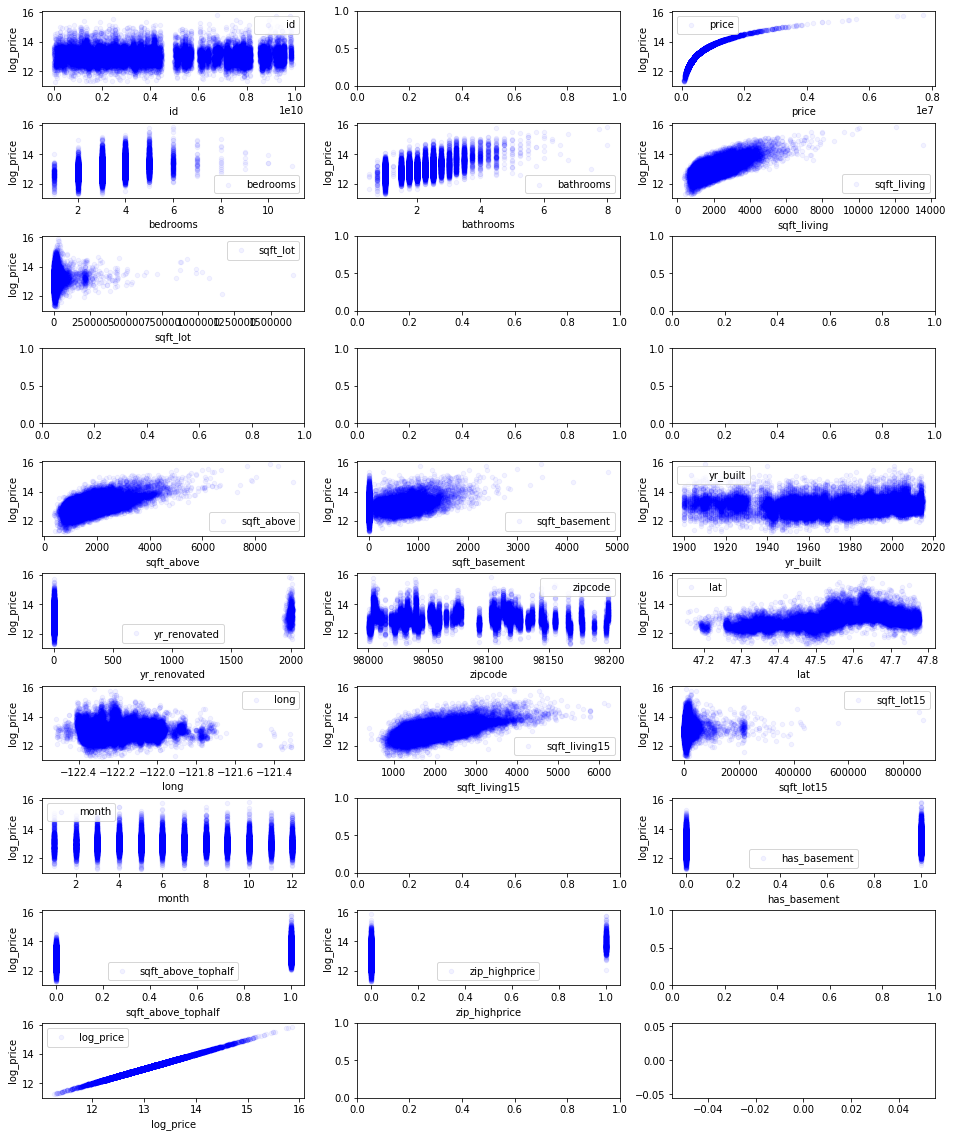

In [11]:
scatter_y(df_clean, 'log_price', )

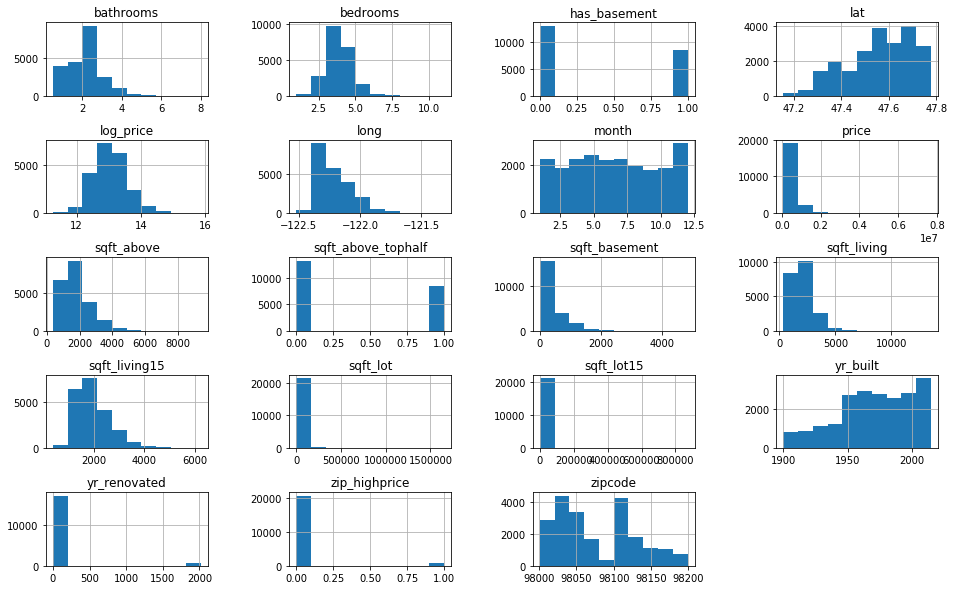

In [12]:
df_clean.iloc[:, 2:].hist(figsize  = [16, 10])
plt.subplots_adjust(wspace=0.5, hspace=0.6)

Taking another look at the distribution of prices after taking the log reveals that we have much closer to a normal distribution of log_price.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


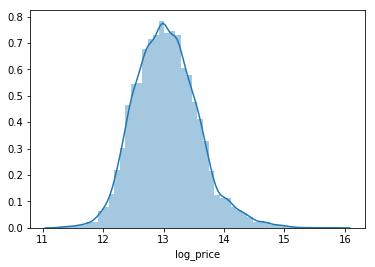

In [13]:
sns.distplot(df_clean.log_price);

## Analyze Correlation between our variables

We need evaluate the correlation matrix to determine whether any of our X variables are highly correlated, which would necessitate removing at least one of them to avoid multicolinearity problems.

To make things easier, we have a function that will find any pairs of variables in the matrix with an absolute value of correlation greater than the second parameter (default = 0.75).

In [14]:
corr_pairs = findcorrpairs(df_clean, 0.5, )
corr_pairs

,Pairs,Correlation
4,"[log_price, price]",0.89
18,"[sqft_above, sqft_living]",0.88
29,"[has_basement, sqft_basement]",0.82
27,"[sqft_above, sqft_above_tophalf]",0.79
9,"[bathrooms, sqft_living]",0.76
19,"[sqft_living, sqft_living15]",0.76
26,"[sqft_above, sqft_living15]",0.73
22,"[sqft_lot, sqft_lot15]",0.72
1,"[price, sqft_living]",0.70
21,"[log_price, sqft_living]",0.70


# Regression Model

## Initial Set-up

From our intuition about the scatter plots above, along with removing a few variables that would be correlated, we take our first shot at linear regression.

Below is our list of initial X variables to try and model upon.

Some intuitive features you would see in the listing for the home include the number of bedrooms and bathrooms and the square footage of the home and property.

In [15]:
x_list = ["bedrooms", 
          "bathrooms", 
          "sqft_above", 
          "sqft_basement", 
          "sqft_lot", 
          "sqft_living15", 
          "sqft_lot15"]

We first run the regression using stats model's OLS function.  Note that the dataframe of X variables must include a column of constants (1).  We have decided to use `'log_price'` as our target (Y).

In [16]:
X = df_clean.loc[:, x_list]
X = sm.add_constant(X)
Y = df_clean['log_price']

The code below fits our model and sets it equal to the variable `model_init`.  We then take a look at the results with the `.summary()` method

In [17]:
model_init = sm.OLS(Y, X).fit()
model_init.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     3287.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:12:03   Log-Likelihood:                -8957.3
No. Observations:               21597   AIC:                         1.793e+04
Df Residuals:                   21589   BIC:                         1.799e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.1661      0.011   1075.859      0.000      12.144      12.188
bedrooms         -0.0577      0.003    -16.495      0.000      -0.065      -0.051
bathrooms         0.0554      0.005     10.984      0.000       0.045       0.065
sqft_above        0.0003   6.01e-06     47.453      0.000       0.000       0.000
sqft_basement     0.0004   6.99e-06     51.433      0.000       0.000       0.000
sqft_lot       2.409e-07   8.68e-08      2.774      0.006    7.07e-08    4.11e-07
sqft_living15     0.0002   5.73e-06     31.259      0.000       0.000       0.000
sqft_lot15    -1.175e-06   1.33e-07     -8.865      0.000   -1.43e-06   -9.15e-07
==============================================================================
Omnibus:                       25.367   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.469
Skew:                           0.031   Prob(JB):                     1.32e-05
Kurtosis:                       2.855   Cond. No.                     2.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<font size="4">Not great...<br>
    Our correlation of 0.516 isn't very good. <br><br> However, the silver lining is that the distribution of residuals appears to be approximately normally distributed based on the histogram of residuals and Q-Q plot below. </font>

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


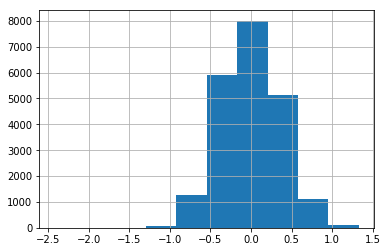

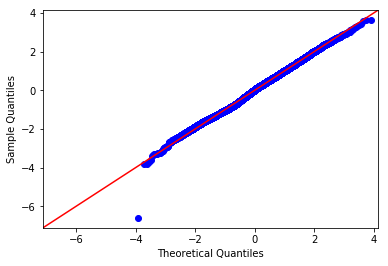

In [18]:
resid1 = model_init.resid
resid1.hist()
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
fig.show()

## Making our model a little smarter

Based on the scatterplot of possible x variables and `'log_price'` we assess that the following variables should have the log function applied in order for their relationships with `'log_price'` to be linear. 

In [19]:
log_list = ['sqft_above', 'sqft_basement',
            'sqft_living15', 'sqft_lot', 'sqft_lot15']

# avoid value of 0 in sqft_basement
df_clean['sqft_basement'] = df_clean['sqft_basement'] + 1

for i in log_list:
    try:
        logcount
    except:
        logcount = 1
        df_clean[i] = df_clean[i].apply(np.log)   #apply(lambda x: np.log(x))



We want to convert our date field into a number of days from an arbitrary starting point so that we can treat each day as a unit.  For lack of a better date, we start from 1/1/1970.  This date does not matter because we will normalize the variable later on.

In [20]:
df_clean['startdate'] = pd.Timestamp('19700101')

df_clean['date_num'] = (df_clean['date'] - df_clean['startdate']).dt.days


## Removing Outliers

We observed that there were some very large outliers in the fields of `'sqft_lot'` and `'sqft_lot15'`.

Our condition below removes any outliers beyond the 99.9th percentile.

The output below the code shows that 38 total outliers were removed.

In [21]:
f1_var = 'sqft_lot'
f2_var = 'sqft_lot15'

f1_lim = df_clean[f1_var].quantile(.999)
f2_lim = df_clean[f2_var].quantile(.999)

n1 = len(df_clean[df_clean[f1_var]>=f1_lim])
n2 = len(df_clean[df_clean[f2_var]>=f2_lim])

filter1 = df_clean[f1_var]<f1_lim
filter2 = df_clean[f2_var]<f2_lim

print('filtered out {} records with {} greater than: {}'.format(n1, f1_var, f1_lim))
print('filtered out {} records with {} greater than: {}'.format(n2, f2_var, f2_lim))

df_filter = df_clean[ filter1 & filter2 ] 

print('{} total records removed'.format(len(df_filter) - len(df_clean)))

filtered out 22 records with sqft_lot greater than: 495972.9480000137
filtered out 22 records with sqft_lot15 greater than: 303191.60000002815
-38 total records removed


Because our variables now contain a different number of rows, we need to recreate the dummy variable dataframe.

This can be achieved by using our `create_dummyframe()` function again, but using the `df_filter` as an input instead.

In [22]:
df_dummy_filter = create_dummyframe(df_filter, categorical_columns)

print('df_dummy shape: {}'.format(df_dummy_filter.shape))
print('\nPreview:')
df_dummy_filter.head()

df_dummy shape: (21559, 37)

Preview:


,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,waterfront_0.0,waterfront_1.0,waterfront_missing,view_0.0,view_1.0,...,grade_12,grade_13,yr_renovated_cat_Never Renovated,yr_renovated_cat_Prior to 2010,yr_renovated_cat_Since 2010 inclusive,yr_renovated_cat_missing,season_Fall,season_Spring,season_Summer,season_Winter
0,1,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


## Scaling our Variables

To make sure no variables have any added or diminished effect simply due to the magnitude of the variable, we will standardize.

Some variables are standardized using the `MinMaxScaler()`, while others use the `StandardScaler()`.

We defaulted to using the `StandardScaler()` except for those variables that can be represented well by a specific domain.  

In this case, we thought that was appropriate for the `'date_num'` and `'yr_built'` data fields because they can be thought of as positions of dates within a specific range of time.

In [23]:
min_max_scaler = preprocessing.MinMaxScaler()
standard_scaler = preprocessing.StandardScaler()


Y = df_filter['log_price']


unadj_list = ['has_basement', 'zip_highprice', 'sqft_lot', 'sqft_above', 
                 'sqft_living15', 'sqft_lot15']

  
min_max_list = ['date_num', 'yr_built']

std_scal_list = ['sqft_living15', 'sqft_lot15']

X_unadj = pd.DataFrame(columns=unadj_list)
X_min_max = pd.DataFrame(columns=min_max_list)
X_std_scal = pd.DataFrame(columns=std_scal_list)



for col_name in min_max_list:
    X_min_max[col_name] = df_filter[col_name]
    
for col_name in std_scal_list:
    X_std_scal[col_name] = df_filter[col_name]

for col_name in unadj_list:
    X_unadj[col_name] = df_filter[col_name]   


X_min_max = pd.DataFrame(data= min_max_scaler.fit_transform(X_min_max.values), columns=X_min_max.columns)

X_std_scal = pd.DataFrame(data= standard_scaler.fit_transform(X_std_scal.values), columns=X_std_scal.columns)




/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Due to filtering, some of our indices became mismatched.  However, our rows still line up, so we reset the axes to concatenate all of our various X dataframes together into one.

In [24]:
X_min_max.reset_index(inplace=True)
X_std_scal.reset_index(inplace=True)
X_unadj.reset_index(inplace=True) 
df_dummy_filter.reset_index(inplace=True)
Y = Y.reset_index().drop(['index'], axis=1)


X_possible = pd.concat([X_min_max, X_std_scal, X_unadj, df_dummy_filter], axis=1)
X_possible.head()



,index,date_num,yr_built,index,sqft_living15,sqft_lot15,index,has_basement,zip_highprice,sqft_lot,...,grade_12,grade_13,yr_renovated_cat_Never Renovated,yr_renovated_cat_Prior to 2010,yr_renovated_cat_Since 2010 inclusive,yr_renovated_cat_missing,season_Fall,season_Spring,season_Summer,season_Winter
0,0,0.420513,0.478261,0,-0.943176,-0.285181,0,0,0,5650,...,0,0,1,0,0,0,1,0,0,0
1,1,0.566667,0.443478,1,-0.432564,-0.199489,1,1,0,7242,...,0,0,0,1,0,0,0,0,0,1
2,2,0.766667,0.286957,2,1.070094,-0.181266,2,0,0,10000,...,0,0,0,0,0,1,0,0,0,1
3,3,0.566667,0.565217,3,-0.913999,-0.313184,3,1,0,5000,...,0,0,1,0,0,0,0,0,0,1
4,4,0.748718,0.756522,4,-0.272086,-0.205349,4,0,0,8080,...,0,0,1,0,0,0,0,0,0,1


We need to remove several columns.  Notably, each of our categorical column groups needs at least one removed to avoid multicolinearity issues.

In [25]:
X_model = X_possible.drop(['floors_1.0', 'waterfront_missing', 'view_0.0', 'condition_1',
                           'grade_3', 'yr_renovated_cat_Never Renovated', 
                           'season_Winter', 'index', 'waterfront_1.0', 'yr_renovated_cat_missing',
                          'grade_6', 'waterfront_0.0', 'condition_2'], axis=1)
# 'zipcode_98001',
X_model = sm.add_constant(X_model)

In [26]:
model_smarter = sm.OLS(Y, X_model).fit()
model_smarter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     1423.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:12:23   Log-Likelihood:                -4282.1
No. Observations:               21559   AIC:                             8632.
Df Residuals:                   21525   BIC:                             8903.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     1.0648      0.007    154.828      0.000       1.051       1.078
date_num                                  0.0691      0.009      7.301      0.000       0.051       0.088
yr_built                                 -0.5404      0.012    -45.211      0.000      -0.564      -0.517
sqft_living15                            -3.0858      0.020   -154.828      0.000      -3.125      -3.047
sqft_lot15                               -0.5628      0.004   -154.828      0.000      -0.570      -0.556
has_basement                              0.1942      0.005     40.493      0.000       0.185       0.204
zip_highprice                             0.4573      0.010     43.793      0.000       0.437       0.478
sqft_lot                               4.727e-07   1.07e-07      4.422      0.000    2.63e-07    6.82e-07
sqft_above                                0.2835      0.009     29.850      0.000       0.265       0.302
sqft_living15                             0.0046   3.11e-05    148.288      0.000       0.005       0.005
sqft_lot15                             2.371e-05   2.14e-07    110.566      0.000    2.33e-05    2.41e-05
floors_1.5                                0.0595      0.008      7.384      0.000       0.044       0.075
floors_2.0                                0.0912      0.006     14.730      0.000       0.079       0.103
floors_2.5                                0.1128      0.024      4.672      0.000       0.065       0.160
floors_3.0                                0.3245      0.014     24.014      0.000       0.298       0.351
view_1.0                                  0.1288      0.017      7.754      0.000       0.096       0.161
view_2.0                                  0.0885      0.010      8.779      0.000       0.069       0.108
view_3.0                                  0.1415      0.014     10.275      0.000       0.115       0.169
view_4.0                                  0.4104      0.017     23.708      0.000       0.376       0.444
condition_3                               0.1823      0.022      8.452      0.000       0.140       0.225
condition_4                               0.1895      0.022      8.752      0.000       0.147       0.232
condition_5                               0.2860      0.022     12.718      0.000       0.242       0.330
grade_4                                  -0.2120      0.058     -3.684      0.000      -0.325      -0.099
grade_5                                  -0.1704      0.020     -8.381      0.000      -0.210      -0.131
grade_7                                   0.2240      0.008     28.346      0.000       0.208       0.239
grade_8                                   0.4236      0.010     44.467      0.000       0.405       0.442
grade_9  

In [27]:
X_model.head()

,const,date_num,yr_built,sqft_living15,sqft_lot15,has_basement,zip_highprice,sqft_lot,sqft_above,sqft_living15,...,grade_9,grade_10,grade_11,grade_12,grade_13,yr_renovated_cat_Prior to 2010,yr_renovated_cat_Since 2010 inclusive,season_Fall,season_Spring,season_Summer
0,1.0,0.420513,0.478261,-0.943176,-0.285181,0,0,5650,7.073270,1340,...,0,0,0,0,0,0,0,1,0,0
1,1.0,0.566667,0.443478,-0.432564,-0.199489,1,0,7242,7.682482,1690,...,0,0,0,0,0,1,0,0,0,0
2,1.0,0.766667,0.286957,1.070094,-0.181266,0,0,10000,6.646391,2720,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.566667,0.565217,-0.913999,-0.313184,1,0,5000,6.956545,1360,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.748718,0.756522,-0.272086,-0.205349,0,0,8080,7.426549,1800,...,0,0,0,0,0,0,0,0,0,0


In [28]:
linreg = LinearRegression()

linreg.fit(X_model, Y)

print(linreg.intercept_)
print(linreg.coef_)


[10.30515397]
[[ 9.88459256e-13  6.91297456e-02 -5.40369800e-01  1.51784517e-07
   3.67637908e-12  1.94196667e-01  4.57257794e-01  4.72726059e-07
   2.83528592e-01  1.04007924e-04 -5.39724836e-07  5.95149280e-02
   9.11891681e-02  1.12822599e-01  3.24534092e-01  1.28755694e-01
   8.85473758e-02  1.41526919e-01  4.10379809e-01  1.82267404e-01
   1.89491791e-01  2.86025897e-01 -2.11999169e-01 -1.70373115e-01
   2.23968841e-01  4.23610384e-01  6.38786230e-01  8.03590605e-01
   9.57505666e-01  1.17007368e+00  1.48485479e+00  1.48218398e-02
   1.22237848e-01  2.27719130e-02  5.47878978e-02  4.55899252e-02]]


## K-Fold Cross Validation

In [29]:
model_kfold = KFold(n_splits=10, shuffle=True)

MSEs = cross_val_score(linreg, X_model, Y, scoring='neg_mean_squared_error', cv=model_kfold)

mean_MSE = np.mean(MSEs)

print(mean_MSE)
print(MSEs)

-0.08743566862297295
[-0.08711249 -0.08915968 -0.08859009 -0.08758801 -0.08776536 -0.09078083
 -0.08629453 -0.08747142 -0.08138061 -0.08821367]


## Comparing different numbers of variables using Recursive Feature Elimination

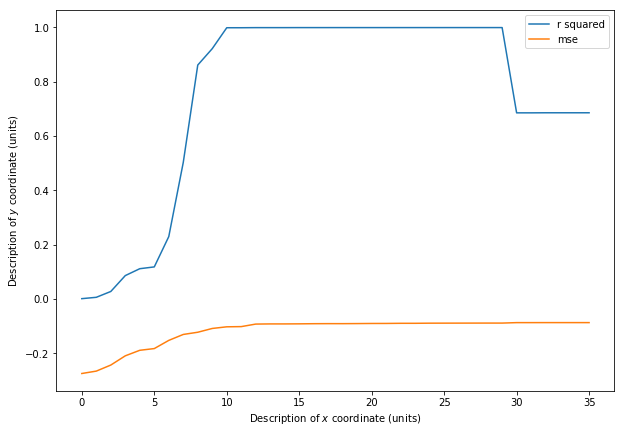

In [30]:
cycles = 10

n = len(X_model.columns)

mse_list = []
r2_list = []
num_var = list(range(1, n+1))

    
for i in range(n):
    selector = RFE(linreg, n_features_to_select = i+1)
    selector = selector.fit(X_model, Y['log_price'])
    selected_X = X_model.columns[selector.support_]
    df_selected = X_model.loc[:, selected_X]

    model_kfold = KFold(n_splits=10, shuffle=True)
    MSEs = cross_val_score(linreg, df_selected , Y, scoring='neg_mean_squared_error', cv=model_kfold)
    mean_MSE = np.mean(MSEs)
    model = sm.OLS(Y, df_selected).fit()
    
    r2_list.append(model.rsquared_adj)
    mse_list.append(mean_MSE)


plt.figure(figsize=(10,7))
plt.plot(r2_list, label='r squared')
plt.xlabel(r"Description of $x$ coordinate (units)")
plt.ylabel(r"Description of $y$ coordinate (units)")
plt.legend()


plt.plot(mse_list, label='mse')
plt.legend()
plt.show()

## Selection of Final Model Variables

In [41]:
selector = RFE(linreg, n_features_to_select = 13)
selector = selector.fit(X_model, Y['log_price'])
selected_X = X_model.columns[selector.support_]
df_selected = X_model.loc[:, selected_X]

model = sm.OLS(Y, df_selected).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.264e+06
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:18:44   Log-Likelihood:                -14432.
No. Observations:               21559   AIC:                         2.889e+04
Df Residuals:                   21546   BIC:                         2.899e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
yr_built         -0.6975      0.015    -45.532      0.000      -0.728      -0.667
has_basement      0.5404      0.007     79.421      0.000       0.527       0.554
zip_highprice     0.4320      0.017     26.145      0.000       0.400       0.464
sqft_above        1.8113      0.002   1091.131      0.000       1.808       1.815
floors_3.0        0.5726      0.020     28.802      0.000       0.534       0.612
view_4.0          0.3386      0.027     12.354      0.000       0.285       0.392
grade_7          -0.0773      0.012     -6.523      0.000      -0.101      -0.054
grade_8          -0.2316      0.013    -17.391      0.000      -0.258      -0.206
grade_9          -0.3754      0.016    -24.057      0.000      -0.406      -0.345
grade_10         -0.4733      0.019    -24.594      0.000      -0.511      -0.436
grade_11         -0.5923      0.028    -21.507      0.000      -0.646      -0.538
grade_12         -0.6389      0.053    -12.118      0.000      -0.742      -0.536
grade_13         -0.8273      0.132     -6.267      0.000      -1.086      -0.569
==============================================================================
Omnibus:                       96.129   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.300
Skew:                           0.072   Prob(JB):                     1.68e-27
Kurtosis:                       3.341   Cond. No.                         306.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


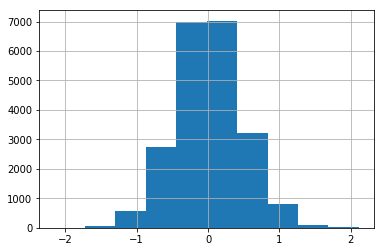

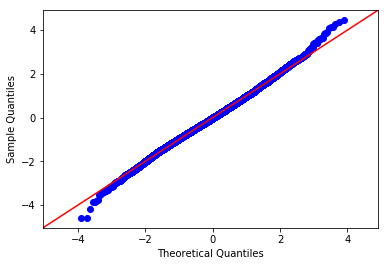

In [42]:
resid1 = model.resid
resid1.hist()
# resid1[resid1 > 1.75]
# plt.scatter(Y, resid1)
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
fig.show()

In [43]:
model_kfold = KFold(n_splits=10, shuffle=True)
MSEs = cross_val_score(linreg, df_selected , Y, scoring='neg_mean_squared_error', cv=model_kfold)
MSEs

array([-0.09192105, -0.09533474, -0.08983216, -0.09205064, -0.09667836,
       -0.09603992, -0.09089318, -0.09291429, -0.09498257, -0.08777355])

In [34]:
df_clean['view'].value_counts()

0.0    19485
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

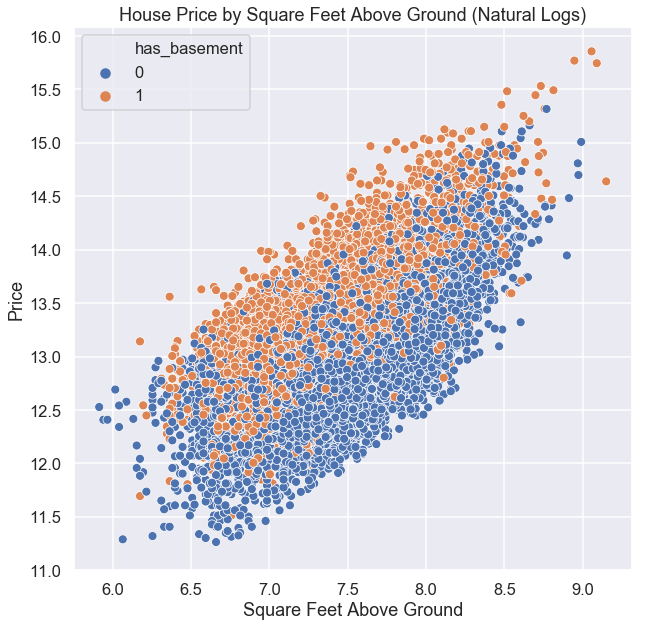

In [68]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style='darkgrid', context='talk')
sns.scatterplot("sqft_above", "log_price", data=df_clean, hue='has_basement' )
plt.yticks(ticks=[11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16])
plt.ylabel('Price')
plt.xlabel('Square Feet Above Ground')
plt.title('House Price by Square Feet Above Ground (Natural Logs)');

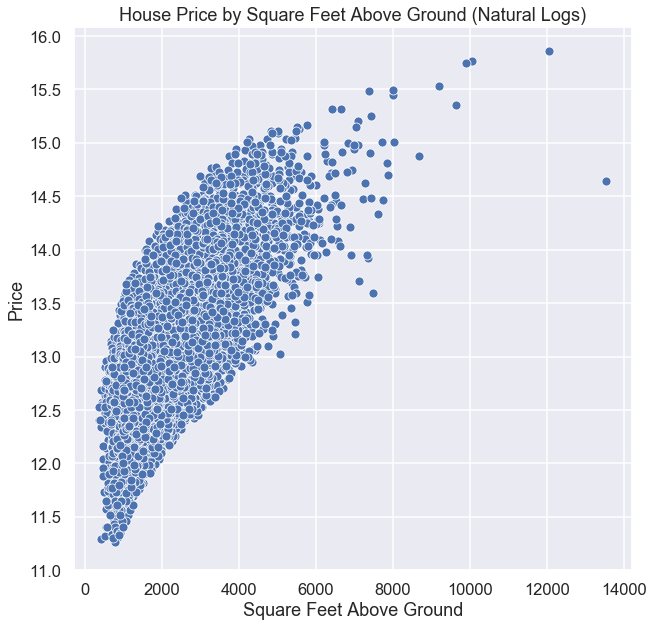

In [67]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style='darkgrid', context='talk')
sns.scatterplot("sqft_living", "log_price", data=df_clean,  )
plt.yticks(ticks=[11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16])
plt.ylabel('Price')
plt.xlabel('Square Feet Living')
plt.title('House Price by Square Feet Above Ground (Natural Logs)');

In [135]:
np.sqrt((((Y-np.mean(Y))**2).sum())/len(Y))

log_price    0.526416
dtype: float64

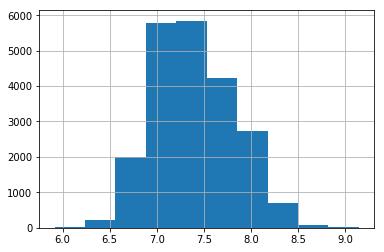

In [149]:
df_clean['sqft_above'].hist()

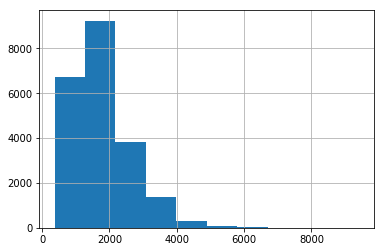

In [150]:
df_raw['sqft_above'].hist()